# RL and Advanced DL: Домашнее задание 2


In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
from collections import defaultdict

In [2]:
from IPython.display import clear_output


In [3]:
from tqdm import tqdm


## Реализуем крестики-нолики

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [5]:


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()

In [6]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    clear_output(wait=True)
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

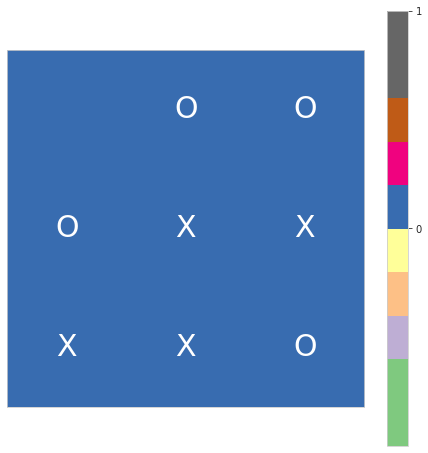

In [7]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=30)

In [8]:
from IPython.display import clear_output

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
from IPython.display import clear_output

## Часть первая: крестики-нолики при помощи Q-обучения

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.


In [9]:
def epsilon_greedy(Q, state, all_actions, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # выбрать жадное действие с вероятностью эпсилон
        return all_actions[np.argmax(Q[state[0]])]
    else:                     # в противном случае выберите действие случайным образом
        return random.choice(all_actions)

In [10]:

def update_Q_sarsamax(alpha, gamma, Q, state, action, R, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    Q_current = Q[state][action]  # оценка в Q-таблице (для текущего состояния, пара действий)
    if next_state is not None:
        maxQ_next = np.max(Q[next_state])
    else: 
        maxQ_next = 0  # значение следующего состояния

    Qsa_new = Q_current + alpha * (R + gamma * maxQ_next - Q_current) # получить обновленное значение 
    return Qsa_new

In [11]:
def plot_graph(rew):    
    clear_output(wait=True)
    plt.figure()
    pd.Series(rew).rolling(500).mean().plot()
    plt.show()
    plt.close()

In [12]:
def find_ind(ar, value):
    for i, el in enumerate(ar):
        if el == value: 
          return i
    return -1


def q_learning(env, alpha = 0.2, gamma = 0.9, 
                    epsilon = 0.04, num_episodes = 100_001, n_size = 3):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
    """
    rewards = []
    env.reset()
    all_actions = env.getEmptySpaces().tolist()
    q_table = defaultdict(lambda: np.random.uniform(size = n_size*n_size).tolist())
    for i in range(1, num_episodes):
        state = env.reset()

        epochs, penalties, reward = 0, 0, 0
        done = False
        cross_actions = []
        cross_states = []

        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == -1: # череда нолей
                action = random.choice(actions)
            else:
                while True:
                        action = epsilon_greedy(q_table, state, all_actions, epsilon)
                        # проверить правила
                        if action not in actions:
                            q_table[state[0]][find_ind(all_actions, action)] = -1000
                        else:
                            break
                cross_actions.append(action)

            next_state, reward, done, info = env.step(action) 

            if done == False:
                reward = 0
            else:
                if env.curTurn == -1: # крестики выиграили
                    reward = 1
                else:                 # нолики выиграли
                    reward = -1

                _state = cross_states[-1]
                _action = find_ind(all_actions, list(cross_actions[-1]))

                q_table[_state][_action] = update_Q_sarsamax(alpha, gamma, q_table, \
                                                _state, _action, reward, next_state[0])    
                state = next_state
            
            if env.curTurn == 1:
                _state = state[0]
                _action = find_ind(all_actions, list(cross_actions[-1]))

                cross_states.append(_state)
                q_table[_state][_action] = update_Q_sarsamax(alpha, gamma, q_table, \
                                                _state, _action, reward, next_state[0])  

                state = next_state

        rewards.append(reward)
        
        if i % 10000 == 0:
            plot_graph(rewards)

#### 3 на 3

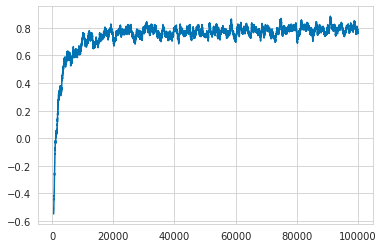

In [13]:
n_size = 3
env = TicTacToe(n_size, n_size, n_size)

q_learning(env)

### 2.Попробуйте обучить стратегии крестиков и ноликов для доски **4х4** и/или 5х5.



In [14]:
new_size = 4
env = TicTacToe(n_rows=new_size, n_cols=new_size, n_win=new_size)

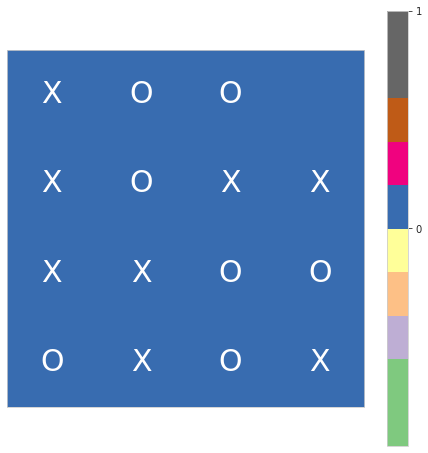

In [15]:
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=30)


## Часть вторая: добавим нейронных сетей


In [16]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [17]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [18]:
class TicTacToe(gym.Env):
    def __init__(self, board_size):
        self.board_size = board_size
        self.n_rows = board_size
        self.n_cols = board_size
        self.n_win = board_size

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        self.n_turns = 0
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        self.actions = self.getEmptySpaces().tolist()

        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()

    def step_random(self, action_index):
        state, reward, done, info =\
                self.step(self.actions[action_index])
        self.n_turns += 1
        
        if not done:
            rand_actions = self.getEmptySpaces()
            rand_action = random.choice(rand_actions)
            _, _, done, _ = self.step(rand_action)
            self.n_turns += 1
            
            if done:
                # мы проиграли
                return self.board, -1, True, info
            else:
                # играем дальше
                return self.board, 0, False, {}
            
        else:
            if reward == -10:
                # неверный ход
                return self.board, -10, True, info
            else:
                if self.n_turns == self.board_size * self.board_size:
                    # ничья
                    return self.board, -0.5, True, info
                else:
                    # мы выиграли
                    return self.board, 1, True, info
        
    def reset_rand(self):
        self.n_turns = 0
        self.done = None
        self.reset()
        return self.board, 0, False, {}

In [19]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    clear_output(wait=True)
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            

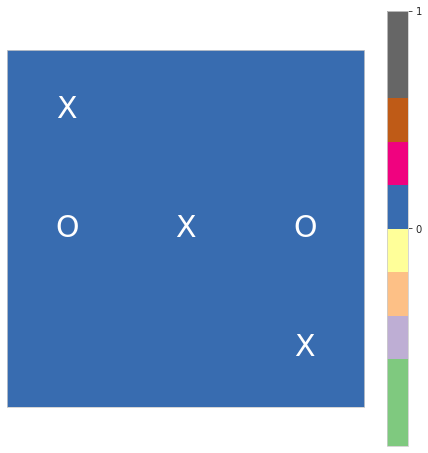

In [20]:
env = TicTacToe(3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=30)

In [21]:
from IPython.display import clear_output

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random


### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же

In [22]:
class TicTacDQNetwork(nn.Module):
    def __init__(self, board_size = 5, padding_size = 2):
        self.board_size = board_size
        nn.Module.__init__(self)
        self.conv1 = torch.nn.Conv2d(1, 16, board_size, 
                                     padding=(padding_size, padding_size))
        self.conv2 = torch.nn.Conv2d(16, 3, board_size, 
                                     padding=(padding_size, padding_size))
        self.l1 = nn.Linear(board_size * board_size * 3, board_size * board_size)

    def forward(self, x):
        # print(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.l1(x.view(-1, self.board_size * self.board_size * 3))
        return x

In [23]:
class TicTacDQN():
    def __init__(self, board_size, padding_size = 2):
        self.board_size = board_size
        self.env = TicTacToe(board_size)
        self.model = TicTacDQNetwork(board_size, padding_size)
        self.memory = ReplayMemory(10_000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        self.rewards = []

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.board_size * self.board_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        state, reward, done, info  = self.env.reset_rand()
        num_step = 0
        while True:
            state_tensor = torch.tensor(state,
                                dtype=torch.float32)\
                            .reshape(1, 1, self.board_size, self.board_size)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                    
            next_state, reward, done, _ = self.env.step_random(action.numpy()[0][0])
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).reshape(1, 1, self.board_size, self.board_size)

            transition = (state_tensor, action, next_state_tensor,
                          torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
            num_step += 1

            if done:
                self.episode_durations.append(num_step)
                self.rewards.append(reward)
                break

    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward =\
                                                            zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state)\
                    .gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#### 3 на 3

In [24]:
tictac_dqn = TicTacDQN(3, 1)


In [25]:
wins = []
for i in tqdm(range(10)):
    tictac_dqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dqn.rewards[-1]
    wins.append(reward)

100%|██████████| 10/10 [00:00<00:00, 111.40it/s]


In [26]:
for i in tqdm(range(10_000)):
    tictac_dqn.run_episode(e=0.04) 

100%|██████████| 10000/10000 [01:40<00:00, 99.15it/s]


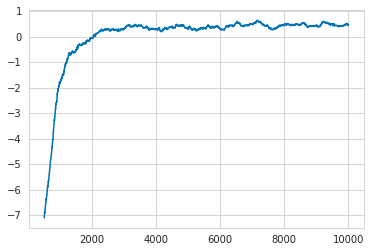

In [27]:
pd.Series(tictac_dqn.rewards).rolling(500).mean().plot()


In [28]:
wins = []
for i in tqdm(range(1000)):
    tictac_dqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dqn.rewards[-1]
    wins.append(reward)

100%|██████████| 1000/1000 [00:01<00:00, 928.47it/s]


In [29]:
import numpy as np
np.mean(wins)

0.8165

#### 5 на 5

In [30]:
tictac_dqn = TicTacDQN(5, 2)

In [31]:
wins = []
for i in tqdm(range(1000)):
    tictac_dqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dqn.rewards[-1]
    wins.append(reward)

100%|██████████| 1000/1000 [00:01<00:00, 713.27it/s]


In [32]:
for i in tqdm(range(10_000)):
    tictac_dqn.run_episode(e=0.04)  

100%|██████████| 10000/10000 [04:44<00:00, 35.14it/s]


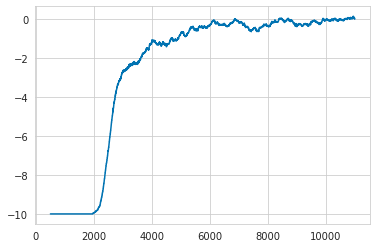

In [33]:
pd.Series(tictac_dqn.rewards).rolling(500).mean().plot()


In [34]:
wins = []
for i in tqdm(range(1000)):
    tictac_dqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dqn.rewards[-1]
    wins.append(reward)

100%|██████████| 1000/1000 [00:03<00:00, 289.49it/s]


In [35]:
np.mean(wins)

0.8

### 4. Реализуйте Double DQN и/или Dueling DQN.

In [36]:
class TicTacDuelingDQNetwork(nn.Module):
    def __init__(self, board_size):
        super(TicTacDuelingDQNetwork, self).__init__()
        
        self.board_size = board_size
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.fc_input_dim = self.feature_size()
        
        self.value_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, self.board_size * self.board_size)
        )

    def forward(self, state):
        features = self.conv(state)
        features = features.view(features.size(0), -1)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        return qvals

    def feature_size(self):
        return self.conv(torch.zeros(1, 1, self.board_size, self.board_size)).view(1, -1).size(1)

In [37]:
class TicTacDuelingDQN():
    def __init__(self, board_size):
        self.board_size = board_size
        self.env = TicTacToe(board_size)
        self.model = TicTacDuelingDQNetwork(board_size)
        self.memory = ReplayMemory(10_000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        self.rewards = []

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.board_size * self.board_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        state, reward, done, info  = self.env.reset_rand()
        num_step = 0
        while True:

            state_tensor = torch.tensor(state, 
                                dtype=torch.float32)\
                            .reshape(1,1,self.board_size, self.board_size)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                    
            next_state, reward, done, _ = self.env.step_random(action.numpy()[0][0])
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).reshape(1,1,self.board_size, self.board_size)

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
            num_step += 1

            if done:
                self.episode_durations.append(num_step)
                self.rewards.append(reward)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward =\
                                                            zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state)\
                    .gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [38]:
tictac_dueldqn = TicTacDuelingDQN(5)


In [39]:
wins = []
for i in tqdm(range(1000)):
    tictac_dueldqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dueldqn.rewards[-1]
    wins.append(reward)

100%|██████████| 1000/1000 [00:01<00:00, 585.05it/s]


In [40]:
for i in tqdm(range(10_000)):
    tictac_dueldqn.run_episode(e=0.05) 

100%|██████████| 10000/10000 [06:02<00:00, 27.62it/s]


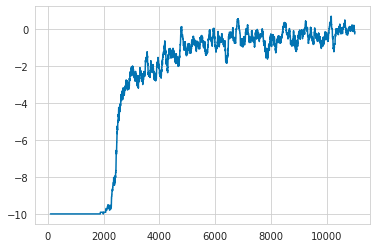

In [41]:
pd.Series(tictac_dueldqn.rewards).rolling(100).mean().plot()


In [42]:
wins = []
for i in tqdm(range(1000)):
    tictac_dueldqn.run_episode(e=0, greedy=True, do_learning=False)
    reward = tictac_dueldqn.rewards[-1]
    wins.append(reward)

100%|██████████| 1000/1000 [00:05<00:00, 185.62it/s]


In [43]:
np.mean(wins)

0.6565

## Часть третья: расширим и углубим поиск

In [44]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
          #print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()

In [45]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    clear_output(wait=True)
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            

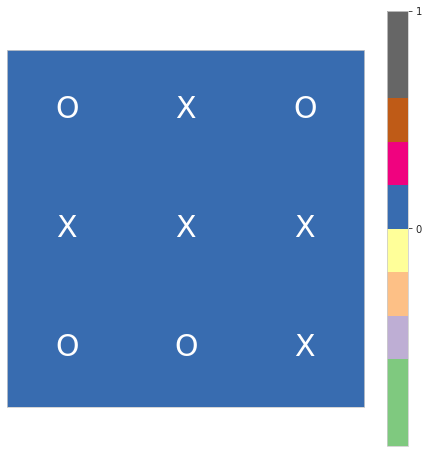

In [46]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=30)


### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте.

In [47]:
from copy import deepcopy

def rollout(env, random_strategy=True, max_depth=None, play_as_crosses=True):
    
    env = deepcopy(env)
    done = env.isTerminal() is not None
    
    while not done:
        action = random.choice(env.emptySpaces)
        _, reward, done, _ = env.step(action)
        
    # inverse
    if play_as_crosses == False:
        reward = -reward
    return reward

def random_policy(env):
    return env.random_available_action()

In [48]:
env = TicTacToe(3, 3, 3)

env.reset()
print(rollout(env, random_policy, random_policy))

env.reset()
print(rollout(env, random_policy, random_policy))

env.reset()
print(rollout(env, random_policy, random_policy))

1
1
1


In [49]:
env.reset()

env.step([1,1])
env.step([1,2]) 
env.step([2,1])
env.step([0,1]) 

env.board

array([[ 0, -1,  0],
       [ 0,  1, -1],
       [ 0,  1,  0]])

In [50]:
np.mean([rollout(env) for _ in range(10_000)])


0.4522

### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


In [51]:
_ = env.reset()

env.step([0,0])
env.step([0,1])

env.step([1,2])
env.step([1,1])

env.step([2,1])
env.step([0,2])

env.board

array([[ 1, -1, -1],
       [ 0, -1,  1],
       [ 0,  1,  0]])

In [52]:
from copy import deepcopy
from math import log, sqrt

class MCTSNode:
    def __init__(self, env=None):
        self.env = deepcopy(env)
        
        self.parent = None
        self.children = []
        
        self.terminal = False
        self.visited = False
        
        self.N = 0
        self.R = 0
        
    def search(self):
        if self.terminal:
            self.N += 1
            return -self.reward
        
        if not self.visited:
            self.visited = True
            self.reward = rollout(self.env)
            
            
            self.R = (self.R * self.N + self.reward) / (self.N + 1)
            self.N += 1
            
            return self.reward
        
        if len(self.children) == 0:
            for action in self.env.emptySpaces:
                new_env = deepcopy(env)
                s, r, d, _ = new_env.step(action)
                new_node = MCTSNode(new_env)
                new_node.parent = self 
                new_node.action = action
                self.children.append(new_node)
                if d:
                    new_node.terminal = True
                    new_node.reward = r
                    
            v = self.children[0].search()
            self.R = (self.R * self.N + v) / (self.N + 1)
            self.N += 1
            return v

In [53]:
env = TicTacToe(3, 3, 3)

_ = env.reset()

env.step([0,0])
env.step([0,1])

env.step([1,2])
env.step([1,1])

env.step([2,1])
env.step([0,2])

env.board

array([[ 1, -1, -1],
       [ 0, -1,  1],
       [ 0,  1,  0]])

In [54]:
mcts = MCTSNode(env)


In [55]:
mcts = MCTSNode(env)
for _ in range(200):
    mcts.search()

In [56]:
max(mcts.children, key=lambda x: x.N).action


array([1, 0])

In [57]:
min(mcts.children, key=lambda x: x.N).action


array([2, 0])

In [58]:
env.board


array([[ 1, -1, -1],
       [ 0, -1,  1],
       [ 0,  1,  0]])

In [63]:
def find_ind(ar, value):
    for i, el in enumerate(ar):
        if sum(el == value) == 2: return i
    return -1

In [64]:
def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    #plot_board(env, pi, fontq=fontq, fontx=fontx)
    mcts = MCTSNode(env)
    for _ in range(100):
        mcts.search()
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        val = max(mcts.children, key=lambda x: x.N).action
        print(val)
        return find_ind(actions, val)

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
    print(reward)
    return reward

In [65]:
val = min(mcts.children, key=lambda x: x.N).action
val

array([2, 0])

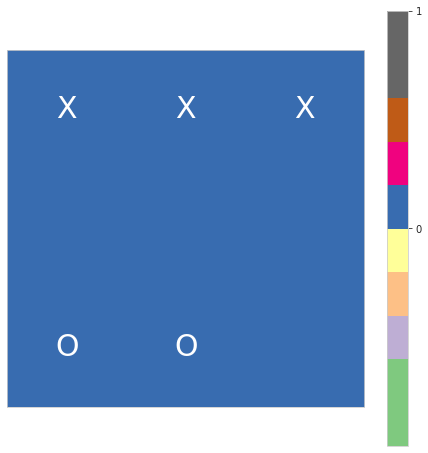

100%|██████████| 1000/1000 [02:21<00:00,  7.06it/s]

1


In [66]:


rew = []

for _ in tqdm(range(1000)):
    env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
    rew.append(plot_test_game(env, None, None, random_crosses=False, fontx=30))

In [67]:
np.mean(rew)


0.63